$$f(x,y)=\frac{1}{2\sqrt{(\pi^2 + x^2 + (y-1)^2)^3}}$$

Покомпонентные плотности распределения:
$$f(x)=\frac{1}{\pi^2 + x^2}$$
$$f(y)=\frac{1}{\pi^2 + (y-1)^2}$$


  X - распределение Коши с $x_0=0, \gamma=\pi$  
  Y - распределение Коши с $y_0=1, \gamma=\pi$ 


Совместные плотности распределения:
$$f(x|y)=\frac{f(x,y)}{f(y)}=\frac{\pi^2 + (y-1)^2}{2\sqrt{(\pi^2 + x^2 + (y-1)^2)^3}}$$
$$f(y|x)=\frac{f(x,y)}{f(x)}=\frac{\pi^2 + x^2}{2\sqrt{(\pi^2 + x^2 + (y-1)^2)^3}}$$

Покомпонентные функции распределения:
$$F(x)=\int_{-\infty}^{x}\frac{1}{\pi^2 + t^2}dt=\frac{1}{\pi}arctg\frac{x}{\pi}+\frac{1}{2}$$
$$F(y)=\int_{-\infty}^{y}\frac{1}{\pi^2 + (t-1)^2}dt=\frac{1}{\pi}arctg\frac{y-1}{\pi}+\frac{1}{2}$$
$$F(x|y)=\int_{-\infty}^{x}\frac{\pi^2 + (y-1)^2}{2\sqrt{(\pi^2 + x^2 + (y-1)^2)^3}}dt=\frac{x}{2\sqrt{\pi^2 + x^2 + (y-1)^2}} + \frac{1}{2}$$

Разложим функцию распределения
$$F(x,y)=F(y)F(x|y)$$

In [37]:
import numpy as np
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statlib.metrics import generate_borders
from scipy.stats import chi2
from statlib.metrics import pearson_chi

plt.style.use('ggplot')

In [5]:
rng = np.arange(-6, 6, 0.1)
X, Y = np.meshgrid(rng, rng)

In [6]:
Z = 1 / (2 * (math.pi**2 + X**2 + (Y - 1)**2)**1.5)

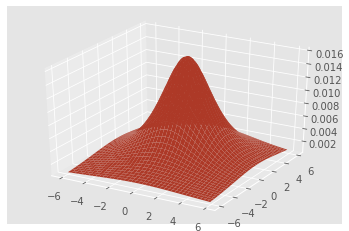

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z);

In [8]:
from statlib.rand.basic_rand import BasicRand
from statlib.rand.engine import LCG

Промоделируем отдельно $F(y)$ и $F(x|y)$:
  
$$\begin{cases}
 \xi_1=\frac{1}{\pi}arctg\frac{y-1}{\pi} + \frac{1}{2} \\ 
 \xi_2=\frac{x}{2\sqrt{a^2+x^2}} + \frac{1}{2} 
\end{cases}, a=\sqrt{\pi^2+(y-1)^2}$$


$$\begin{cases}
  y=1+\pi tg(\pi \xi_1 - \frac{\pi}{2}) \\
  x=sgn(2\xi_2 - 1) sgn(1-(2\xi_2-1)^2) \frac{a\left | 2\xi_2 - 1 \right |}{\sqrt{\left | 1-(2\xi_2-1)^2 \right |}}
\end{cases}$$

In [9]:
from statlib.metrics import get_bins_count

gen = BasicRand(LCG())

n = 1000000

ranges = [[-6, 6], [-6, 6]]
bins = get_bins_count(n)

In [10]:
def build_sample(n, gen):
    xi1 = np.array([gen.next() for _ in range(n)])
    xi2 = np.array([gen.next() for _ in range(n)])
    
    y_p = 1 + math.pi * np.tan(math.pi * xi1 - math.pi / 2)

    a = np.sqrt(math.pi**2 + (y_p - 1)**2)
    t = 2 * xi2 - 1

    x_p = np.sign(t) * np.sign(1 - t**2) * a * np.abs(t) / np.sqrt(np.abs(1 - t**2))
    
    return x_p, y_p

x_p, y_p = build_sample(n, gen)

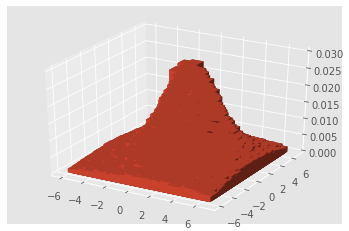

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(x_p, y_p, bins=bins, range=ranges, normed=True)

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz)

plt.show()

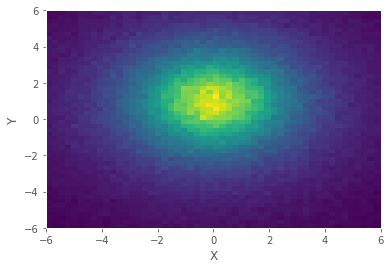

In [12]:
plt.ylabel('Y')
plt.xlabel('X')
plt.hist2d(x_p, y_p, bins=bins, range=ranges);

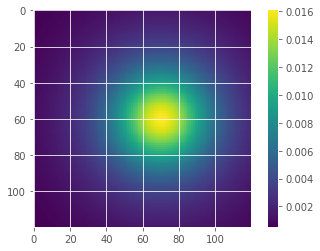

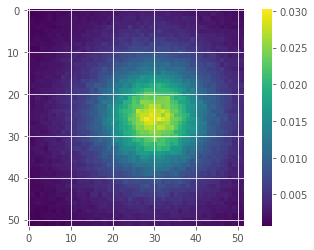

In [13]:
plt.imshow(Z.T)
plt.colorbar()
plt.show()

plt.imshow(hist)
plt.colorbar()
plt.show()

#### Границы для равновероятностной гистограммы

In [14]:
x_p_sorted = np.array(sorted(x_p))
y_p_sorted = np.array(sorted(y_p))

borders_eq_x = generate_borders(x_p_sorted, bins)
borders_eq_y = generate_borders(y_p_sorted, bins)

#### Проверка на соответствие закону распределения

In [34]:
def f(x, y):
    return 1 / (2 * (math.pi**2 + x**2 + (y - 1)**2)**1.5)


def pearson_chi_2d(x_p, y_p, bins_x, bins_y):
    n, m = len(bins_x) - 1, len(bins_y) - 1
    cnt = len(x_p)
    
    chi_tab, _, _ = np.histogram2d(x_p, y_p, bins=[bins_x, bins_y], density=True)

    chi_val = 0
    for i in range(n):
        for j in range(m):
            pij = f((bins_x[i] + bins_x[i + 1]) / 2, (bins_y[j] + bins_y[j + 1]) / 2)
            chi_val += (chi_tab[i, j] - pij)**2 / pij
    
    return chi_val

In [36]:
exp_criteria = pearson_chi_2d(x_p, y_p, borders_eq_x, borders_eq_y)
theor_criteria = chi2.ppf(0.05, len(borders_eq_x) * len(borders_eq_y))

print('Экспериментальное значение критерия: {}, теоретическое значение критерия: {}'.format(exp_criteria, theor_criteria))

if exp_criteria < theor_criteria:
    print('Критерий выполнен')

Экспериментальное значение критерия: 1.6778356458648909, теоретическое значение критерия: 2791.5338511216537
Критерий выполнен


#### Гистограмма для X

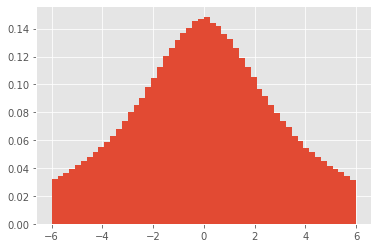

In [17]:
vals_x, bins_x, _ = plt.hist(x_p, bins=bins, range=ranges[0], density=True);

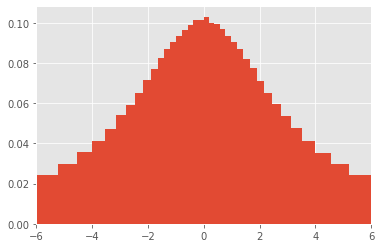

In [18]:
plt.xlim(ranges[0])
vals_int_x, bins_int_x, _ = plt.hist(x_p_sorted, bins=borders_eq_x, density=True)

#### Гистограмма для Y

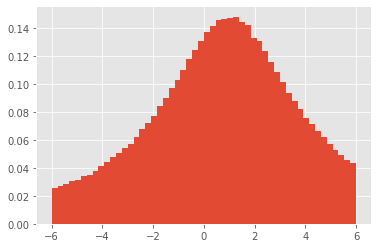

In [19]:
vals_y, bins_y, _ = plt.hist(y_p, bins=bins, range=ranges[1], density=True);

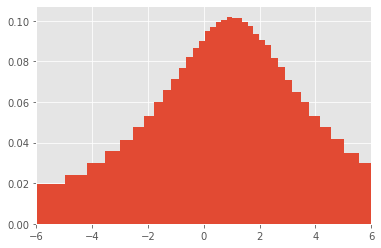

In [20]:
plt.xlim(ranges[1])
vals_int_y, bins_int_y, _ = plt.hist(y_p_sorted, bins=borders_eq_y, density=True)

#### Функция распределения для X

In [21]:
def get_val_counts(arr):
    counts = {}
    for x in arr:
        counts[x] = counts.get(x, 0) + 1
        
    return counts

def build_distribution_function(x_var):
    counts = get_val_counts(x_var)
    
    F = [0]
    for i in range(len(x_var) - 1):
        F.append(F[i] + counts[x_var[i]] / n)
        
    return F

In [22]:
F_x = build_distribution_function(x_p_sorted)

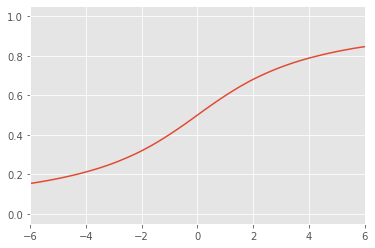

In [23]:
plt.xlim(ranges[0])
plt.step(x_p_sorted, F_x)

#### Функция распределения для Y

In [24]:
F_y = build_distribution_function(y_p_sorted)

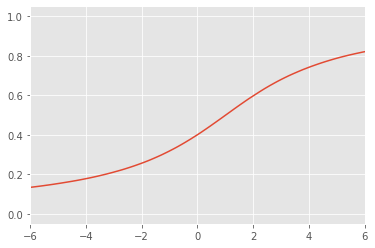

In [25]:
plt.xlim(ranges[1])
plt.step(y_p_sorted, F_y)

In [38]:
def F_x(x):
    return 1 / math.pi * math.atan(x / math.pi) + 0.5

def F_y(y):
    return 1 / math.pi * math.atan((y - 1) / math.pi) + 0.5

In [41]:
def pearson_1d(bins, vals, F):
    n = np.sum(vals)
    chi_sqr = pearson_chi(bins, vals, F, n)
    table_pearson = chi2.ppf(0.05, len(bins))

    print('Экспериментальное значение критерия: {}, теоретическое значение критерия: {}'.format(chi_sqr, table_pearson))

    if chi_sqr < table_pearson:
        print('Критерий принят')

##### Критерий согласия для X

In [47]:
print('Критерий согласия для X:')
pearson_1d(bins_int_x, vals_int_x, F_x)

Критерий согласия для X:
Экспериментальное значение критерия: 16.21092202052519, теоретическое значение критерия: 38.1162180624794
Критерий принят


##### Критерий согласия для Y

In [48]:
print('Критерий согласия для Y:')
pearson_1d(bins_int_y, vals_int_y, F_y)

Критерий согласия для Y:
Экспериментальное значение критерия: 16.263968087156524, теоретическое значение критерия: 38.1162180624794
Критерий принят


### Точечные оценки

Найдем точеные оценки:  

1. Мода для X, Y
2. Медиана для X, Y
3. Корелляция


#### Мода

In [26]:
def mode(vals, bins):
    mode_pos = np.argmax(vals)
    # берем середину интервала для лучшего приближения
    return (bins[mode_pos] + bins[mode_pos + 1]) / 2

mode_x = mode(vals_x, bins_x)
mode_y = mode(vals_y, bins_y)


print('Мода X:', mode_x)
print('Мода Y:', mode_y)

Мода X: 0.11538461538461542
Мода Y: 1.2692307692307696


#### Медиана

In [27]:
x_med = np.median(x_p)
y_med = np.median(y_p)

print('Медиана X:', x_med)
print('Медиана Y:', y_med)

Медиана X: -0.0013526901442064978
Медиана Y: 1.009174335583478


#### Проверка независимости

Проверим независимость X и Y с помощью критерия хи квадрат

In [28]:
def chi2_criteria_tab(x_p, y_p, bins_x, bins_y):
    n, m = len(bins_x) - 1, len(bins_y) - 1
    cnt = len(x_p)
    
    chi_tab, _, _ = np.histogram2d(x_p, y_p, bins=[bins_x, bins_y], density=True)
    x_probs = np.array([np.sum(chi_tab[i, :]) for i in range(n)])
    y_probs = np.array([np.sum(chi_tab[:, i]) for i in range(m)])
    
    chi_val = 0
    for i in range(n):
        for j in range(m):
            pij = x_probs[i] * y_probs[j]
            chi_val += (chi_tab[i, j] - pij)**2 / pij
    
    return chi_val * cnt

In [29]:
exp_criteria = chi2_criteria_tab(x_p, y_p, borders_eq_x, borders_eq_y)
theor_criteria = chi2.ppf(0.05, len(borders_eq_x) * len(borders_eq_y))

print('Экспериментальное значение критерия: {}, теоретическое значение критерия: {}'.format(exp_criteria, theor_criteria))

if exp_criteria < theor_criteria:
    print('Критерий выполнен')

Экспериментальное значение критерия: 56509664.08480907, теоретическое значение критерия: 2791.5338511216537


### Доверительные интервалы

#### Мода

In [53]:
def bootstrap_mode(alpha, gen, nsamples, nelements):
    n = nsamples
    bins = get_bins_count(nelements)
    modes_x = []
    modes_y = []
    
    for i in range(nsamples):
        x_p, y_p = build_sample(nelements, gen)
        
        x_p_sorted = np.array(sorted(x_p))
        y_p_sorted = np.array(sorted(y_p))

        borders_eq_x = generate_borders(x_p_sorted, bins)
        borders_eq_y = generate_borders(y_p_sorted, bins)
        
        vals_x, bins_x = np.histogram(x_p, bins=borders_eq_x, density=True)
        vals_y, bins_y = np.histogram(y_p, bins=borders_eq_y, density=True)
        
        modes_x.append(mode(vals_x, bins_x))
        modes_y.append(mode(vals_y, bins_y))
    

    modes_x.sort()
    modes_y.sort()
    
    interval_x = (modes_x[int(nsamples * alpha / 2)], modes_x[int(nsamples * (1 - alpha / 2))])
    interval_y = (modes_y[int(nsamples * alpha / 2)], modes_y[int(nsamples * (1 - alpha / 2))])
    
    return interval_x, interval_y

In [54]:
for nsamples in [50, 100, 1000]:
    for nelements in [100, 300, 1000]:
        print('Количество выборок: {}, количество элементов в выборке: {}\n'.format(nsamples, nelements))
        
        mode_interval_x, mode_interval_y = bootstrap_mode(0.05, gen, nsamples, nelements)

        print('Мода X:', mode_x)
        print('Доверительный интервал моды для X:', mode_interval_x)

        print()

        print('Мода Y:', mode_y)
        print('Доверительный интервал моды для Y:', mode_interval_y)

Количество выборок: 50, количество элементов в выборке: 100

Мода X: 0.11538461538461542
Доверительный интервал моды для X: (-2.2520659889847994, 1.9187743358416935)

Мода Y: 1.2692307692307696
Доверительный интервал моды для Y: (-1.1670148009930466, 3.1377750953489776)
Количество выборок: 50, количество элементов в выборке: 300

Мода X: 0.11538461538461542
Доверительный интервал моды для X: (-1.697433613144102, 1.6154618732216768)

Мода Y: 1.2692307692307696
Доверительный интервал моды для Y: (-0.766508300988707, 2.6170070228268063)
Количество выборок: 50, количество элементов в выборке: 1000

Мода X: 0.11538461538461542
Доверительный интервал моды для X: (-0.7850183616147552, 1.761934073285303)

Мода Y: 1.2692307692307696
Доверительный интервал моды для Y: (-0.7965099127784614, 2.3079546234485093)
Количество выборок: 100, количество элементов в выборке: 100

Мода X: 0.11538461538461542
Доверительный интервал моды для X: (-2.405584107569654, 1.9211297395782618)

Мода Y: 1.269230769230

#### Медиана

In [32]:
def bootstrap_median(alpha, gen, nsamples, nelements):
    n = nsamples
    bins = get_bins_count(nelements)
    modes_x = []
    modes_y = []
    
    for i in range(nsamples):
        x_p, y_p = build_sample(nelements, gen)

        modes_x.append(np.mediand(x_p))
        modes_y.append(np.mediand(y_p))
    

    modes_x.sort()
    modes_y.sort()
    
    interval_x = (modes_x[int(nelements * alpha / 2)], modes_x[int(nelements * (1 - alpha / 2))])
    interval_y = (modes_y[int(nelements * alpha / 2)], modes_y[int(nelements * (1 - alpha / 2))])
    
    return interval_x, interval_y

In [33]:
bootstrap_median(0.05, gen, 1000, 1000)

((-1.4088646402542082, 1.3425145083583894),
 (-0.35893765722368526, 2.354395705458841))